Verify whether tonality can be preserved after note quantization and lower pitch resolution.

In [147]:
import numpy as np
import librosa
import matplotlib.pyplot as plt


In [148]:
from scipy.stats import mode


def hz_to_cent_voiced(pitch_in_hz):
    voiced_idx = np.where(pitch_in_hz != 0)
    pitch_in_cent = np.zeros(len(voiced_idx[0]))
    for i in range(len(pitch_in_cent)):
        # convert to cent
        pitch_in_cent[i] = 1200 * np.log2(pitch_in_hz[voiced_idx[0][i]] / 440.0)
        
    return pitch_in_cent


# fold pitch values onto the 12 semitones in an octave
def fold_into_octave(pitch_in_cent):
    # convert to note with cents
    pitch_in_cent %= 1200
    return pitch_in_cent


def quantize_pitch(pitches_hz, resolution_cents):
    """
    Quantize pitch values to the nearest specified resolution in cents.

    Parameters:
    - pitches_hz: numpy array of pitch values in Hz.
    - resolution_cents: The quantization resolution in cents. Defaults to 50.

    Returns:
    - A numpy array of quantized pitch values in cent.
    """

    # Reference pitch (A4 = 440 Hz)
    A4 = 440.0
    # Convert pitches from Hz to cents relative to A4
    pitches_cents = np.zeros(len(pitches_hz))
    voiced_idx = np.where(pitches_hz != 0)
    pitches_cents[voiced_idx]= 1200 * np.log2(pitches_hz[voiced_idx] / A4)

    # Quantize the pitch values
    pitches_cents = np.round(pitches_cents / resolution_cents) * resolution_cents

    return pitches_cents, voiced_idx[0]



def quantize_time(pitch, window_duration_ms=215, spacing_ms=20):
    """
    Quantize the pitch array based on majority voting within non-overlapping windows.
    
    Args:
    pitch (numpy array): The input pitch array.
    window_duration_ms (int): Duration of each window in milliseconds.
    spacing_ms (int): Time interval between samples in milliseconds.
    
    Returns:
    numpy array: The quantized pitch array.
    """
    # Calculate the number of samples per window
    samples_per_window = window_duration_ms // spacing_ms
    
    # Calculate the number of full windows that can fit in the array
    num_windows = len(pitch) // samples_per_window
    
    # Initialize the quantized array
    quantized_pitch = np.zeros_like(pitch)
    
    # Process each window
    for i in range(num_windows):
        start_index = i * samples_per_window
        end_index = start_index + samples_per_window
        window = pitch[start_index:end_index]
        
        # Compute the majority vote (mode) for the current window
        window_mode = mode(window)[0]

        # Set all values in this window to the mode
        quantized_pitch[start_index:end_index] = window_mode
    
    return quantized_pitch



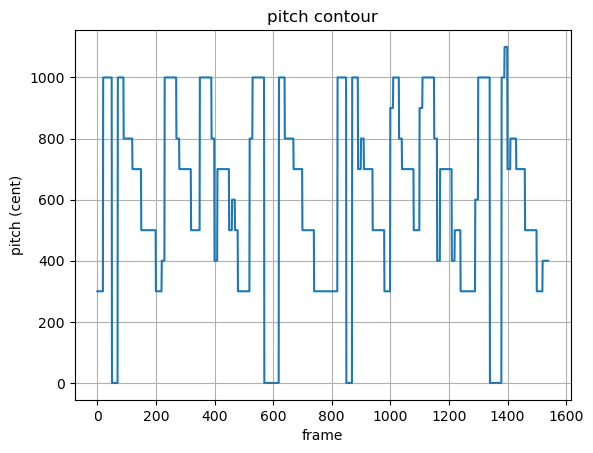

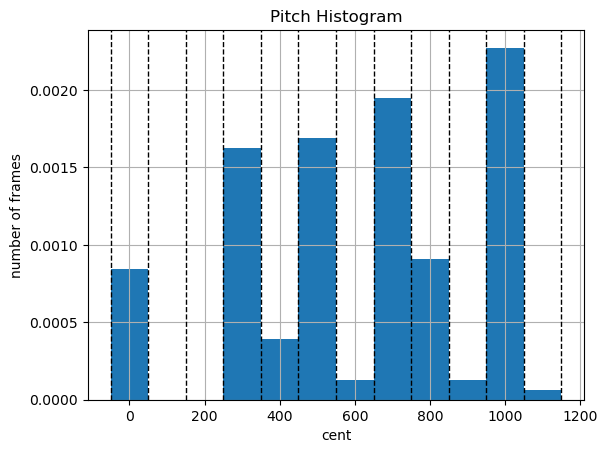

In [157]:
pitch = np.loadtxt('test_audio/C_major/abcSong_vocal_predict.txt')
# pitch = np.loadtxt('test_audio/C_major/audio_test_vocal_predict.txt')

# Convert to cent & Quantizatize
pitch = quantize_time(pitch)
pitch, voiced_idx = quantize_pitch(pitch, resolution_cents=100)
pitch = fold_into_octave(pitch[voiced_idx])

x = np.arange(len(pitch))
plt.plot(x, pitch)
plt.title('pitch contour')
plt.xlabel('frame')
plt.ylabel('pitch (cent)')
plt.grid()

# Define the bin edges for the histogram
# Bin edges from -50 to 1150, creating 12 bins
bin_edges = np.arange(-50, 1201, 100)

# Draw histogram
plt.figure()
plt.hist(pitch, bins=bin_edges, density=True)
plt.title('Pitch Histogram')
plt.xlabel('cent')
plt.ylabel('number of frames')
plt.grid()
# Add vertical lines at the boundaries of each semitone
for x in range(-50, 1201, 100):
    plt.axvline(x, color='black', linestyle='--', linewidth=1)

# Show the plot
plt.show()


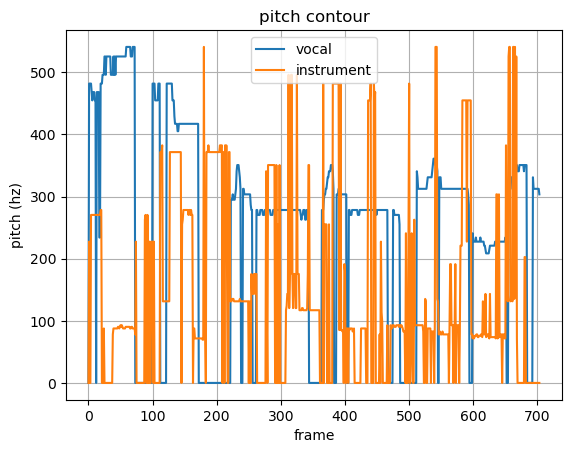

In [167]:
pitch_vocal = np.loadtxt('test_audio/predict_result/second_time3_predict.txt')
pitch_instr = np.loadtxt('test_audio/predict_result_music/second_time3_predict.txt')

# Convert to cent & Quantizatize
# pitch_vocal = quantize_time(pitch_vocal)
# pitch_instr = quantize_time(pitch_instr)
# pitch_vocal, voiced_idx = quantize_pitch(pitch_vocal, resolution_cents=100)
# pitch_instr, voiced_idx = quantize_pitch(pitch_instr, resolution_cents=100)

x = np.arange(len(pitch_vocal))
plt.plot(x, pitch_vocal, label='vocal')
plt.plot(x, pitch_instr, label='instrument')
plt.title('pitch contour')
plt.xlabel('frame')
plt.ylabel('pitch (hz)')
plt.legend()
plt.grid()